In [1]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics.pairwise import euclidean_distances

from sklearn.feature_extraction.text import TfidfVectorizer

import plotly.express as px
import plotly.figure_factory as ff

import numpy as np
import pandas as pd

import sys, os
import re

from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.cluster import FeatureAgglomeration
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, entropy
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier

import time

In [2]:
df = pd.read_csv("objectivity_train.csv")
df['Label'] = df['Label'].map({'subjective': 1, 'objective': 0})

frequency_columns = ['CC', 'CD', 'DT', 'EX', 'FW', 'INs', 'JJ',
       'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS',
       'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TOs', 'UH', 'VB',
       'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB',
       'baseform', 'pronouns1st', 'pronouns2nd', 'pronouns3rd', 'compsupadjadv',
       'past', 'imperative', 'present3rd', 'present1st2nd', 'Quotes', 'questionmarks', 'exclamationmarks',
       'fullstops', 'commas', 'semicolon', 'colon', 'ellipsis', 'semanticobjscore','semanticsubjscore']

frequency_norm_cols = [col + '_norm' for col in frequency_columns]
train_cols = frequency_norm_cols #+ ['totalWordsCount_norm','sentence1st','sentencelast']


for col in frequency_columns:
    ss = StandardScaler()
    if col not in ['Quotes', 'questionmarks', 'exclamationmarks',
       'fullstops', 'commas', 'semicolon', 'colon', 'ellipsis', 'semanticobjscore','semanticsubjscore']:
        df[col + '_norm'] = ss.fit_transform(df[col].values.reshape(-1, 1))
    else:
        df[col + '_norm'] = ss.fit_transform((df[col] / df['totalWordsCount']).values.reshape(-1, 1))



ss_word_count = StandardScaler()

df['totalWordsCount_norm'] = ss_word_count.fit_transform(df['totalWordsCount'].values.reshape(-1, 1))
df['totalWordsCount_norm']/= df['totalWordsCount_norm'].max()

df = df.reset_index(drop=True)

In [6]:
new_curr_scores = []
for k in range(2, 20, 1):
    clf = KMeans(n_clusters=k, init='k-means++', n_init=50, max_iter=300, 
             tol=0.0001, verbose=0, random_state=42, copy_x=True, algorithm='lloyd')
    start_time = time.time()
    clf.fit(df[train_cols])
    end_time = time.time()
    curr_sil = silhouette_score(df[train_cols], clf.labels_)
    curr_cal = calinski_harabasz_score(df[train_cols], clf.labels_)
    curr_dav = davies_bouldin_score(df[train_cols], clf.labels_)
    curr_labels = pd.DataFrame(clf.labels_, columns=['label'])
    for g, g_df in curr_labels.groupby("label"):
        curr_dists = euclidean_distances(df[train_cols].iloc[g_df.index.tolist()], clf.cluster_centers_[g].reshape(1, -1)).reshape(1, -1)[0]
        curr_sums = np.sum(np.square(curr_dists))
        curr_means = np.mean(curr_dists)
        new_curr_scores.append((k, curr_sil, curr_cal, curr_dav, clf.inertia_, g_df.shape[0], curr_sums, curr_means, end_time-start_time))
        print(new_curr_scores[-1])

(2, 0.31009657750299674, 413.67259824133987, 1.4027937917116018, 37469.02792183915, 629, 14723.51973239781, 4.302869162177199, 0.3820040225982666)
(2, 0.31009657750299674, 413.67259824133987, 1.4027937917116018, 37469.02792183915, 371, 22745.508189441345, 7.141210627505136, 0.3820040225982666)
(3, 0.25317892866894753, 304.3421723448515, 1.6172723640477022, 32908.70971916429, 402, 14295.961990339521, 5.791773966420503, 0.42599916458129883)
(3, 0.25317892866894753, 304.3421723448515, 1.6172723640477022, 32908.70971916429, 528, 11073.214162352086, 3.9602651947696472, 0.42599916458129883)
(3, 0.25317892866894753, 304.3421723448515, 1.6172723640477022, 32908.70971916429, 70, 7539.533566472691, 9.6486705026368, 0.42599916458129883)
(4, 0.16725434205936762, 240.93007390460215, 1.9761990331450536, 30712.299461050607, 429, 8673.892842173023, 3.7323071605685683, 0.5169963836669922)
(4, 0.16725434205936762, 240.93007390460215, 1.9761990331450536, 30712.299461050607, 42, 5484.78422004425, 10.80950

(12, 0.1028104503571833, 107.9182374816826, 2.0472782072114337, 24074.288657693418, 93, 1640.3932330158984, 3.7019507111673366, 0.8629980087280273)
(12, 0.1028104503571833, 107.9182374816826, 2.0472782072114337, 24074.288657693418, 120, 3930.004179815619, 5.593383288804367, 0.8629980087280273)
(12, 0.1028104503571833, 107.9182374816826, 2.0472782072114337, 24074.288657693418, 51, 2393.3257449373396, 6.681906383309247, 0.8629980087280273)
(12, 0.1028104503571833, 107.9182374816826, 2.0472782072114337, 24074.288657693418, 127, 2896.5178439774045, 4.607083719514564, 0.8629980087280273)
(12, 0.1028104503571833, 107.9182374816826, 2.0472782072114337, 24074.288657693418, 139, 2359.9217877062347, 4.0187660734377, 0.8629980087280273)
(12, 0.1028104503571833, 107.9182374816826, 2.0472782072114337, 24074.288657693418, 10, 1546.3404171515863, 12.072799453773857, 0.8629980087280273)
(12, 0.1028104503571833, 107.9182374816826, 2.0472782072114337, 24074.288657693418, 323, 3687.58697045658, 3.2139734

(17, 0.06363103829383569, 85.23284219521902, 1.974888245583792, 22200.722049628806, 117, 1819.3423616243756, 3.846096650014109, 1.2450039386749268)
(17, 0.06363103829383569, 85.23284219521902, 1.974888245583792, 22200.722049628806, 32, 1884.9101411801307, 7.40639707818387, 1.2450039386749268)
(17, 0.06363103829383569, 85.23284219521902, 1.974888245583792, 22200.722049628806, 44, 1207.2719609844312, 5.076688600611585, 1.2450039386749268)
(17, 0.06363103829383569, 85.23284219521902, 1.974888245583792, 22200.722049628806, 185, 1797.5737742361325, 2.9055937941197536, 1.2450039386749268)
(17, 0.06363103829383569, 85.23284219521902, 1.974888245583792, 22200.722049628806, 61, 1714.286421998431, 5.1741807547300995, 1.2450039386749268)
(17, 0.06363103829383569, 85.23284219521902, 1.974888245583792, 22200.722049628806, 1, 0.0, 0.0, 1.2450039386749268)
(17, 0.06363103829383569, 85.23284219521902, 1.974888245583792, 22200.722049628806, 147, 3678.4053963288015, 4.852512758929622, 1.2450039386749268

In [236]:
scores_df = pd.DataFrame(new_curr_scores, columns=['k', 'silhouette', 'calinski_harabasz', 'davies_bouldin', 'inertia', 'cluster_size', 'cluster_sum_dist', 'cluster_mean_dist','time'])
fig = px.line(scores_df[['k','silhouette','calinski_harabasz','davies_bouldin','inertia']].drop_duplicates(),
       x='k', y=['silhouette','davies_bouldin','inertia'], title='Objectivity Dataset k vs Evaluation Metrics - K-Means')
fig.update_yaxes(title='Score')
fig.update_xaxes(title='k')

In [3]:
clf = KMeans(n_clusters=4, init='k-means++', n_init=50, max_iter=300, 
             tol=0.0001, verbose=0, random_state=42, copy_x=True, algorithm='auto')
clf.fit(df[train_cols])

C:\Users\DKARACA\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1318: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


KMeans(algorithm='auto', n_clusters=4, n_init=50, random_state=42)

In [9]:
tsne = TSNE(n_components=2, random_state=42)
tsne_coords = pd.DataFrame(tsne.fit_transform(df[train_cols]), columns=['x','y'])
tsne_coords['cluster_label'] = clf.labels_
tsne_coords['cluster_label'] = 'Cluster#' + tsne_coords['cluster_label'].astype(str)

fig_kmeans = px.scatter(tsne_coords, x='x', y='y', color='cluster_label', title='K-Means Clusters - K=4')
fig_kmeans.update_layout(showlegend=False)

C:\Users\DKARACA\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

C:\Users\DKARACA\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [10]:
new_gmm_curr_scores = []
for k in range(2, 20, 1):
    gmm = GaussianMixture(n_components=k, init_params='kmeans', n_init=50, max_iter=300, random_state=42)
    start_time = time.time()
    gmm.fit(df[train_cols])
    end_time = time.time()
    curr_preds = gmm.predict(df[train_cols])
    curr_sil = silhouette_score(df[train_cols], curr_preds)
    curr_cal = calinski_harabasz_score(df[train_cols], curr_preds)
    curr_dav = davies_bouldin_score(df[train_cols], curr_preds)
    curr_labels = pd.DataFrame(curr_preds, columns=['label'])
    for g, g_df in curr_labels.groupby("label"):
        curr_dists = euclidean_distances(df[train_cols].iloc[g_df.index.tolist()], gmm.means_[g].reshape(1, -1)).reshape(1, -1)[0]
        curr_sums = np.sum(np.square(curr_dists))
        curr_means = np.mean(curr_dists)
        new_gmm_curr_scores.append((k, curr_sil, curr_cal, curr_dav, g_df.shape[0], curr_sums, curr_means, end_time-start_time))
        print(new_gmm_curr_scores[-1])

(2, 0.2601916625092698, 367.93423623086113, 1.4439481567590613, 526, 11310.863697681514, 4.007021495981717, 2.147989511489868)
(2, 0.2601916625092698, 367.93423623086113, 1.4439481567590613, 474, 27412.816320800273, 6.919329983250053, 2.147989511489868)
(3, 0.2001454244648819, 261.1551560713775, 1.5720221448960883, 529, 18769.93751195629, 5.77664420103072, 6.368999004364014)
(3, 0.2001454244648819, 261.1551560713775, 1.5720221448960883, 407, 8164.70351769713, 3.6992837197441752, 6.368999004364014)
(3, 0.2001454244648819, 261.1551560713775, 1.5720221448960883, 64, 7844.9562717408635, 10.356640272579497, 6.368999004364014)
(4, 0.2307350129462061, 192.47432571874918, 1.7821351437768436, 6, 2197.8556420001883, 17.54917363568032, 7.7450034618377686)
(4, 0.2307350129462061, 192.47432571874918, 1.7821351437768436, 431, 15892.068540903385, 5.9141642480583885, 7.7450034618377686)
(4, 0.2307350129462061, 192.47432571874918, 1.7821351437768436, 63, 7784.637639722458, 10.404560991294247, 7.7450034

(12, 0.05913106992025063, 81.10203576663825, 3.0680697482325106, 244, 5100.973820684396, 4.433945972419736, 28.20954465866089)
(12, 0.05913106992025063, 81.10203576663825, 3.0680697482325106, 32, 2338.7439536688753, 8.011074199950363, 28.20954465866089)
(12, 0.05913106992025063, 81.10203576663825, 3.0680697482325106, 54, 3027.0190673167463, 4.882541058824101, 28.20954465866089)
(12, 0.05913106992025063, 81.10203576663825, 3.0680697482325106, 96, 2886.746149182342, 5.353219766497159, 28.20954465866089)
(12, 0.05913106992025063, 81.10203576663825, 3.0680697482325106, 27, 1014.2738835973707, 5.928158083119827, 28.20954465866089)
(12, 0.05913106992025063, 81.10203576663825, 3.0680697482325106, 49, 1986.0044303467375, 6.176818321965215, 28.20954465866089)
(12, 0.05913106992025063, 81.10203576663825, 3.0680697482325106, 77, 2180.744724733694, 5.2230615699628515, 28.20954465866089)
(12, 0.05913106992025063, 81.10203576663825, 3.0680697482325106, 23, 1779.3619801025422, 8.517183696892332, 28.2

(17, 0.03489144346761934, 73.69655310824105, 2.436458757731221, 22, 916.7585464475461, 6.225629510088024, 34.3714337348938)
(17, 0.03489144346761934, 73.69655310824105, 2.436458757731221, 85, 1474.0458542066958, 4.067653124504669, 34.3714337348938)
(17, 0.03489144346761934, 73.69655310824105, 2.436458757731221, 44, 599.4395167549296, 3.3488433369504675, 34.3714337348938)
(17, 0.03489144346761934, 73.69655310824105, 2.436458757731221, 31, 749.3706014846885, 4.784522293122214, 34.3714337348938)
(17, 0.03489144346761934, 73.69655310824105, 2.436458757731221, 10, 1070.9333889201948, 9.848093526243199, 34.3714337348938)
(17, 0.03489144346761934, 73.69655310824105, 2.436458757731221, 45, 1058.995497336465, 4.151556510693785, 34.3714337348938)
(17, 0.03489144346761934, 73.69655310824105, 2.436458757731221, 8, 940.4579450002084, 10.474666765282922, 34.3714337348938)
(17, 0.03489144346761934, 73.69655310824105, 2.436458757731221, 60, 1939.0898262257476, 5.556691231115892, 34.3714337348938)
(17,

In [237]:
scores_df = pd.DataFrame(new_gmm_curr_scores, columns=['k', 'silhouette', 'calinski_harabasz', 'davies_bouldin', 'cluster_size', 'cluster_sum_dist', 'cluster_mean_dist','time'])
fig = px.line(scores_df[['k','silhouette','calinski_harabasz','davies_bouldin']].drop_duplicates(),
       x='k', y=['silhouette','davies_bouldin'], title='Objectivity Dataset k vs Evaluation Metrics - GMM')
fig.update_yaxes(title='Score')
fig.update_xaxes(title='k')

In [6]:
gmm = GaussianMixture(n_components=4, init_params='kmeans', n_init=1, max_iter=300, random_state=42)
gmm.fit(df[train_cols])
curr_labels = gmm.predict(df[train_cols])

In [10]:
clustering_res = pd.concat([
    df[['TextID','Label']], pd.DataFrame(clf.labels_, columns=['kmeans_label']), pd.DataFrame(curr_labels, columns=['gmm_label'])
], axis=1)

px.scatter(
    clustering_res.groupby("kmeans_label").agg({'TextID': 'count', 'Label': 'mean'}) \
    .rename(columns={'TextID': 'Number of Data Points', 'Label': 'Mean Class'}),
    x='Number of Data Points', y='Mean Class', size='Number of Data Points',
    title='K-Means Clustering vs Classification Labels'
)

In [11]:
px.scatter(
    clustering_res.groupby("gmm_label").agg({'TextID': 'count', 'Label': 'mean'}) \
    .rename(columns={'TextID': 'Number of Data Points', 'Label': 'Mean Class'}),
    x='Number of Data Points', y='Mean Class', size='Number of Data Points',
    title='GMM Clustering vs Classification Labels'
)

In [14]:
tsne_coords['gmm_label'] = curr_labels
tsne_coords['gmm_label'] = 'Cluster#' + tsne_coords['gmm_label'].astype(str)

fig_gmm = px.scatter(tsne_coords, x='x', y='y', color='gmm_label', title='GMM Clusters - K=4')
fig_gmm.update_layout(showlegend=False)

fig_kmeans.show()
fig_gmm.show()

In [15]:
pca = PCA()
pca.fit(df[train_cols])

pca_proj = pca.transform(df[train_cols])
pca_proj.shape

(1000, 55)

[Text(0.5, 1.0, 'Distribution of Singular Values')]

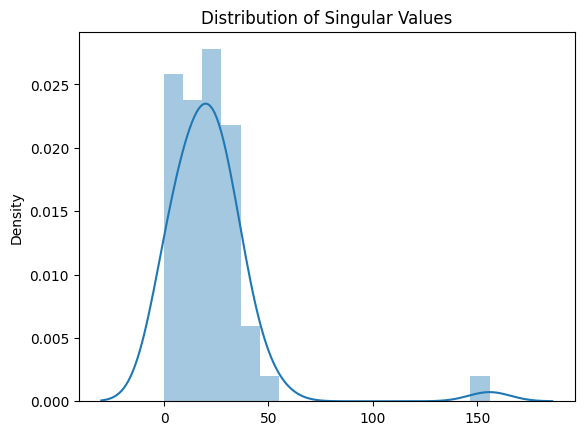

In [239]:
sns.distplot(pca.singular_values_).set(title='Distribution of Singular Values')

In [242]:
fig = px.line(np.cumsum(pca.explained_variance_ratio_), title='Explained Variance vs Number of Principal Components')
fig.update_yaxes(title="Explained Variance")
fig.update_xaxes(title="Number of Principal Components Used")
fig.update_layout(showlegend=False)

In [18]:
### focusing on first 15 components as they explain 80% of the variance

pca_labels = {str(comp_idx): f"PC{comp_idx+1}: {var:.1f}%" for comp_idx, var in enumerate(pca.explained_variance_ratio_[:5] * 100)}

fig_pca = px.scatter_matrix(
    pca_proj[:, :5],
    labels=pca_labels,
    dimensions=range(len(pca_labels)),
    color=df['Label']
)

fig_pca.update_traces(diagonal_visible=False)
fig_pca.show()

C:\Users\DKARACA\AppData\Roaming\Python\Python39\site-packages\plotly\express\_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



In [99]:
fig_comps = ff.create_distplot(pca.components_[:15], group_labels=[f"PC{i+1}" for i in range(15)], show_hist=False)
fig_comps.update_layout(height=800)
fig_comps.show()

In [100]:
for i, comp in enumerate(pca.components_[:15]):
    print(f"COMP{i+1}")
    curr = sorted(enumerate(comp), key=lambda x: x[1], reverse=True)[:30]
    print([(train_cols[e[0]], e[1]) for e in curr])
    print('\n')

COMP1
[('CD_norm', 0.1935048102907131), ('FW_norm', 0.1932313147967703), ('baseform_norm', 0.1915769670229959), ('PRP$_norm', 0.19152059888440284), ('MD_norm', 0.18707058424833325), ('INs_norm', 0.18683157921856905), ('SYM_norm', 0.18559480777183207), ('VBD_norm', 0.17808534294858153), ('NNPS_norm', 0.1768249600612892), ('POS_norm', 0.1747099102624424), ('compsupadjadv_norm', 0.17245066174990484), ('present3rd_norm', 0.17231643500096128), ('VBP_norm', 0.17230793795741806), ('VBN_norm', 0.17179395117505236), ('present1st2nd_norm', 0.17178789231972816), ('UH_norm', 0.1716067795079926), ('PRP_norm', 0.17137103460855563), ('imperative_norm', 0.17123871224999496), ('pronouns3rd_norm', 0.16982779669677653), ('VBG_norm', 0.16864513982503213), ('LS_norm', 0.1649811582382307), ('WP$_norm', 0.1569970079731407), ('WDT_norm', 0.15595451857169243), ('JJ_norm', 0.1459780864476191), ('EX_norm', 0.1453117825995332), ('VBZ_norm', 0.14467619131957077), ('RBS_norm', 0.14442856101068974), ('JJR_norm', 0.1

In [140]:
pca_recons = []
for i in range(pca.components_.shape[0]):
    curr_recons = np.dot(pca_proj[:, :i+1], pca.components_[:i+1, :])
    pca_recons.append((i+1, np.sum((df[train_cols].values - curr_recons) ** 2, axis=1).mean()))

In [142]:
px.line(pd.DataFrame(pca_recons, columns=['Number of Components', 'Reconstruction Error']), 
        x='Number of Components', y='Reconstruction Error', title='PCA Reconstruction Error vs Number of Principal Components')

In [101]:
pca_clust_input = pca_proj[:, :15] ## first 15 comps make up >= 80% of variance

In [14]:
ica = FastICA(n_components=40, whiten='unit-variance')
ica_proj = ica.fit_transform(df[train_cols])

<AxesSubplot: ylabel='Density'>

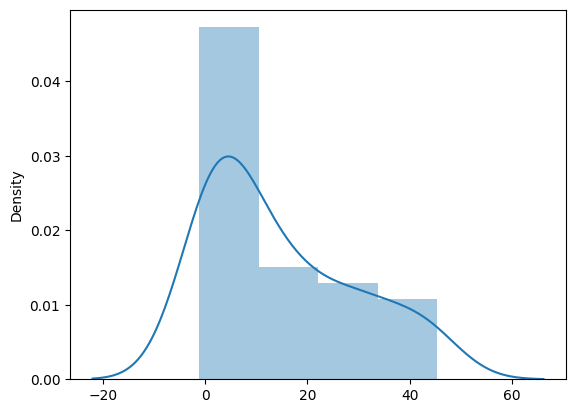

In [21]:
ica_mix_kurtosis = []
for i in range(ica.mixing_.T.shape[0]):
    curr = kurtosis(ica.mixing_.T[i])
    ica_mix_kurtosis.append(curr)

sns.distplot(ica_mix_kurtosis)

[Text(0.5, 1.0, 'Kurtosis Distribution of Independent Components')]

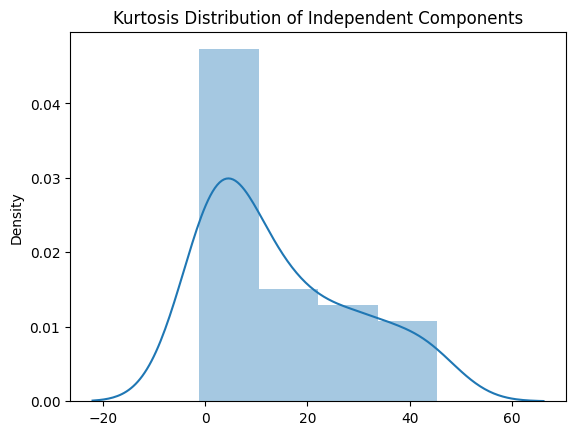

In [22]:
sns.distplot(ica_mix_kurtosis).set(title="Kurtosis Distribution of Independent Components")

In [23]:
for i, kurt in sorted(enumerate(ica_mix_kurtosis), key=lambda x: x[1], reverse=True):
    print(f"COMP{i+1}", kurt)
    curr = sorted(enumerate(ica.mixing_.T[i]), key=lambda x: x[1], reverse=True)
    print([(train_cols[e[0]], e[1]) for e in curr[:10]])
    print('\n')
    print([(train_cols[e[0]], e[1]) for e in curr[-10:]])
    print('\n')

COMP3 45.33458074654114
[('CC_norm', 0.07251693972900812), ('VB_norm', 0.06642749720913418), ('past_norm', 0.06641047050680524), ('WDT_norm', 0.06397358185801344), ('RB_norm', 0.05245220735726833), ('baseform_norm', 0.04739586636904395), ('JJR_norm', 0.04110039408928967), ('Quotes_norm', 0.039452215180579606), ('VBG_norm', 0.03522014500189107), ('EX_norm', 0.03489548591308902)]


[('imperative_norm', -0.015740432273688026), ('UH_norm', -0.015891040605011116), ('VBP_norm', -0.018244810311810942), ('present3rd_norm', -0.01827124396512275), ('WP$_norm', -0.02069823535900699), ('semanticsubjscore_norm', -0.02241633973617389), ('fullstops_norm', -0.025369635236948032), ('exclamationmarks_norm', -0.027750804008157128), ('semanticobjscore_norm', -0.04170117533466977), ('questionmarks_norm', -0.8621236769840019)]


COMP26 43.83165094616192
[('exclamationmarks_norm', 0.7534478033766062), ('semanticsubjscore_norm', 0.06802024225004671), ('colon_norm', 0.03732871932425346), ('pronouns1st_norm', 0

In [24]:
ica_recons, comps_covered, ica_comp_lists = [], [], {}
for i, kurt in sorted(enumerate(ica_mix_kurtosis), key=lambda x: x[1], reverse=True):
    comps_covered.append(i)
    curr_mixing = ica.mixing_[:, sorted(comps_covered)]
    curr_proj = ica_proj[:, sorted(comps_covered)]
    
    ica_comp_lists[len(comps_covered)] = comps_covered
        
    ica_recons.append((len(comps_covered), np.sum((df[train_cols].values - np.dot(curr_proj, curr_mixing.T)) ** 2, axis=1).mean()))

In [25]:
px.line(pd.DataFrame(ica_recons, columns=['Number of Components', 'Reconstruction Error']), 
        x='Number of Components', y='Reconstruction Error', title='ICA Reconstruction Error vs Number of Components')

In [32]:
grp_recons_scores = []
for n in range(2, 56):
    print(n)
    for _ in range(100):
        grp = GaussianRandomProjection(n_components=n)
        grp_proj = grp.fit_transform(df[train_cols])

        grp_recons_scores.append((n, np.sum((df[train_cols].values - grp.inverse_transform(grp_proj)) ** 2, axis=1).mean()))

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55


In [38]:
grp_recons_df = pd.DataFrame(grp_recons_scores, columns=['n_comps', 'reconstruction_error'])
grp_recons_vars = grp_recons_df.groupby("n_comps").agg({'reconstruction_error': 'var'}).reset_index().rename(columns={'reconstruction_error': 'recons_var'})

In [244]:
fig = px.box(grp_recons_df, x='n_comps', y='reconstruction_error', title="Random Projection Reconstruction Error across 100 Trials vs n")
fig.update_yaxes(title="Reconstruction Error")
fig.update_xaxes(title="n")
fig.show()

In [158]:
fig = px.line(grp_recons_df.groupby("n_comps").agg({'reconstruction_error': 'min'}).reset_index(), 
              x='n_comps', y='reconstruction_error', title='Random Projections Reconstruction Error vs Number of Components')
fig.show()

In [16]:
grp_projs_23 = []
for _ in range(100):
    grp = GaussianRandomProjection(n_components=23)
    grp_proj = grp.fit_transform(df[train_cols])
    grp_projs_23.append((grp_proj, np.sum((df[train_cols].values - grp.inverse_transform(grp_proj)) ** 2, axis=1).mean()))
    
grp_projs_38 = []
for _ in range(100):
    grp = GaussianRandomProjection(n_components=38)
    grp_proj = grp.fit_transform(df[train_cols])
    grp_projs_38.append((grp_proj, np.sum((df[train_cols].values - grp.inverse_transform(grp_proj)) ** 2, axis=1).mean()))
    
grp_projs_23 = sorted(grp_projs_23, key=lambda x: x[1], reverse=False)[0][0]
grp_projs_38 = sorted(grp_projs_38, key=lambda x: x[1], reverse=False)[0][0]

grp_projs_23.shape, grp_projs_38.shape

((1000, 23), (1000, 38))

In [71]:
fa_recons_scores = []
for n in range(2, 56):
    fa = FeatureAgglomeration(n_clusters=n, affinity='euclidean', linkage='average', compute_distances=True)
    fa_proj = fa.fit_transform(df[train_cols])

    fa_recons_scores.append((n, np.sum((df[train_cols].values - fa.inverse_transform(fa_proj)) ** 2, axis=1).mean(), fa.labels_))

In [245]:
fa_recons_df = pd.DataFrame(fa_recons_scores, columns=['n_comps', 'reconstruction_error', 'labels'])
fig = px.line(fa_recons_df, x='n_comps', y='reconstruction_error', title='Feature Agglomeration Reconstruction Error vs Number of Components')
fig.update_yaxes(title="Reconstruction Error")
fig.update_xaxes(title="n")
fig.show()

In [98]:
fa_labels = fa_recons_df.labels.tolist()
cooc_dict = {col: {col_i: 0 for col_i in train_cols} for col in train_cols}
for lab in fa_labels:
    labs_zipped = list(zip(lab, train_cols))
    curr_labs = {}
    for e in labs_zipped:
        if e[0] not in curr_labs:
            curr_labs[e[0]] = []
        curr_labs[e[0]].append(e[1])
    for lab_cluster, elems in curr_labs.items():
        for e in elems:
            for e_i in elems:
                cooc_dict[e][e_i]+= 1
                
cooc_mat = [[cooc_dict[col][col_i] for col_i in train_cols] for col in train_cols]

fig = px.imshow(cooc_mat,
                x=train_cols,
                y=train_cols
               )
fig.update_layout(height=1100, width=1100, title='Co-Occurrence of Features in Clusters')
fig.show()

In [12]:
fa = FeatureAgglomeration(n_clusters=13, affinity='euclidean', linkage='average', compute_distances=True)
fa_proj_13 = fa.fit_transform(df[train_cols])

fa = FeatureAgglomeration(n_clusters=25, affinity='euclidean', linkage='average', compute_distances=True)
fa_proj_25 = fa.fit_transform(df[train_cols])

In [162]:
def run_exps(x_mat, algo='kmeans'):
    ret_scores = []
    for k in range(2, 20, 1):
        if algo == 'kmeans':
            curr_clf = KMeans(n_clusters=k, init='k-means++', n_init=50, max_iter=300, 
             tol=0.0001, verbose=0, random_state=42, copy_x=True, algorithm='lloyd')
        else:
            curr_clf = GaussianMixture(n_components=k, init_params='kmeans', n_init=50, max_iter=300, random_state=42)
        start_time = time.time()
        curr_clf.fit(x_mat)
        end_time = time.time()
        if algo == 'kmeans':
            curr_preds = curr_clf.labels_
        else:
            curr_preds = curr_clf.predict(x_mat)
        curr_sil = silhouette_score(x_mat, curr_preds)
        curr_cal = calinski_harabasz_score(x_mat, curr_preds)
        curr_dav = davies_bouldin_score(x_mat, curr_preds)
        curr_labels = pd.DataFrame(curr_preds, columns=['label'])
        for g, g_df in curr_labels.groupby("label"):
            if algo == 'kmeans':
                curr_dists = euclidean_distances(x_mat[g_df.index.tolist()], curr_clf.cluster_centers_[g].reshape(1, -1)).reshape(1, -1)[0]
            else:
                curr_dists = euclidean_distances(x_mat[g_df.index.tolist()], curr_clf.means_[g].reshape(1, -1)).reshape(1, -1)[0]
            curr_sums = np.sum(np.square(curr_dists))
            curr_means = np.mean(curr_dists)
            ret_scores.append((k, curr_sil, curr_cal, curr_dav, g_df.shape[0], curr_sums, curr_means, end_time-start_time))
    return ret_scores

In [170]:
reduced_versions = [
    ('ICA - 25 Comps - KMeans', ica_proj[:, sorted(ica_comp_lists[25])], 'kmeans'),
    ('ICA - 37 Comps - KMeans', ica_proj[:, sorted(ica_comp_lists[37])], 'kmeans'),
    ('ICA - 25 Comps - GMM', ica_proj[:, sorted(ica_comp_lists[25])], 'gmm'),
    ('ICA - 37 Comps - GMM', ica_proj[:, sorted(ica_comp_lists[37])], 'gmm'),
    ('FA - 13 Comps - KMeans', fa_proj_13, 'kmeans'),
    ('FA - 25 Comps - KMeans', fa_proj_25, 'kmeans'),
    ('FA - 13 Comps - GMM', fa_proj_13, 'gmm'),
    ('FA - 25 Comps - GMM', fa_proj_25, 'gmm'),
    ('PCA - 15 Comps - KMeans', pca_proj[:, :15], 'kmeans'),
    ('PCA - 15 Comps - GMM', pca_proj[:, :15], 'gmm'),
    ('RP - 23 Comps - KMeans', grp_projs_23, 'kmeans'),
    ('RP - 38 Comps - KMeans', grp_projs_38, 'kmeans'),
    ('RP - 23 Comps - GMM', grp_projs_23, 'gmm'),
    ('RP - 38 Comps - GMM', grp_projs_38, 'gmm')
]

exp_results = []
for elem in reduced_versions:
    print(elem[0])
    curr_exp_res = run_exps(elem[1], elem[2])
    exp_results.append((elem[0], curr_exp_res))

ICA - 25 Comps - KMeans
ICA - 37 Comps - KMeans
ICA - 25 Comps - GMM
ICA - 37 Comps - GMM
FA - 13 Comps - KMeans
FA - 25 Comps - KMeans
FA - 13 Comps - GMM
FA - 25 Comps - GMM
PCA - 15 Comps - KMeans
PCA - 15 Comps - GMM
RP - 23 Comps - KMeans
RP - 38 Comps - KMeans
RP - 23 Comps - GMM
RP - 38 Comps - GMM


In [175]:
exp_res_df = []
for e in exp_results:
    for elem in e[1]:
        exp_res_df.append((e[0], elem[0], elem[1], elem[2], elem[3]))
        
exp_res_df = pd.DataFrame(exp_res_df, columns=['exp_name', 'k', 'silhouette', 'calinski_harabasz', 'davies_bouldin']).drop_duplicates()

px.line(exp_res_df, x='k', y=['silhouette', 'calinski_harabasz', 'davies_bouldin'], facet_col='exp_name', facet_col_wrap=3)

In [17]:
kmeans_pca = KMeans(n_clusters=5, init='k-means++', n_init=50, max_iter=300, 
             tol=0.0001, verbose=0, random_state=42, copy_x=True, algorithm='lloyd')
kmeans_pca.fit(pca_proj[:, :15])

gmm_pca = GaussianMixture(n_components=6, init_params='kmeans', n_init=50, max_iter=300, random_state=42)
gmm_pca.fit(pca_proj[:, :15])

GaussianMixture(max_iter=300, n_components=6, n_init=50, random_state=42)

In [26]:
kmeans_ica = KMeans(n_clusters=3, init='k-means++', n_init=50, max_iter=300, 
             tol=0.0001, verbose=0, random_state=42, copy_x=True, algorithm='lloyd')
kmeans_ica.fit(ica_proj[:, sorted(ica_comp_lists[25])])

gmm_ica = GaussianMixture(n_components=4, init_params='kmeans', n_init=50, max_iter=300, random_state=42)
gmm_ica.fit(ica_proj[:, sorted(ica_comp_lists[25])])

GaussianMixture(max_iter=300, n_components=4, n_init=50, random_state=42)

In [27]:
kmeans_rp = KMeans(n_clusters=4, init='k-means++', n_init=50, max_iter=300, 
             tol=0.0001, verbose=0, random_state=42, copy_x=True, algorithm='lloyd')
kmeans_rp.fit(grp_projs_23)

gmm_rp = GaussianMixture(n_components=4, init_params='kmeans', n_init=50, max_iter=300, random_state=42)
gmm_rp.fit(grp_projs_23)

GaussianMixture(max_iter=300, n_components=4, n_init=50, random_state=42)

In [28]:
kmeans_fa = KMeans(n_clusters=5, init='k-means++', n_init=50, max_iter=300, 
             tol=0.0001, verbose=0, random_state=42, copy_x=True, algorithm='lloyd')
kmeans_fa.fit(fa_proj_13)

gmm_fa = GaussianMixture(n_components=6, init_params='kmeans', n_init=50, max_iter=300, random_state=42)
gmm_fa.fit(fa_proj_13)

GaussianMixture(max_iter=300, n_components=6, n_init=50, random_state=42)

In [193]:
tsne_coords['ica_kmeans_label'] = kmeans_ica.labels_
tsne_coords['ica_kmeans_label'] = 'Cluster#' + tsne_coords['ica_kmeans_label'].astype(str)

tsne_coords['ica_gmm_label'] = gmm_ica.predict(ica_proj[:, sorted(ica_comp_lists[25])])
tsne_coords['ica_gmm_label'] = 'Cluster#' + tsne_coords['ica_gmm_label'].astype(str)

tsne_coords['fa_kmeans_label'] = kmeans_fa.labels_
tsne_coords['fa_kmeans_label'] = 'Cluster#' + tsne_coords['fa_kmeans_label'].astype(str)

tsne_coords['fa_gmm_label'] = gmm_fa.predict(fa_proj_13)
tsne_coords['fa_gmm_label'] = 'Cluster#' + tsne_coords['fa_gmm_label'].astype(str)

tsne_coords['pca_kmeans_label'] = kmeans_pca.labels_
tsne_coords['pca_kmeans_label'] = 'Cluster#' + tsne_coords['pca_kmeans_label'].astype(str)

tsne_coords['pca_gmm_label'] = gmm_pca.predict(pca_proj[:, :15])
tsne_coords['pca_gmm_label'] = 'Cluster#' + tsne_coords['pca_gmm_label'].astype(str)

tsne_coords['rp_kmeans_label'] = kmeans_rp.labels_
tsne_coords['rp_kmeans_label'] = 'Cluster#' + tsne_coords['rp_kmeans_label'].astype(str)

tsne_coords['rp_gmm_label'] = gmm_rp.predict(grp_projs_23)
tsne_coords['rp_gmm_label'] = 'Cluster#' + tsne_coords['rp_gmm_label'].astype(str)

fig_fa_gmm = px.scatter(tsne_coords, x='x', y='y', color='fa_gmm_label', title='FA GMM Clusters - K=6')
fig_fa_gmm.update_layout(showlegend=False)
fig_fa_kmeans = px.scatter(tsne_coords, x='x', y='y', color='fa_kmeans_label', title='FA KMeans Clusters - K=5')
fig_fa_kmeans.update_layout(showlegend=False)

fig_pca_gmm = px.scatter(tsne_coords, x='x', y='y', color='pca_gmm_label', title='PCA GMM Clusters - K=6')
fig_pca_gmm.update_layout(showlegend=False)
fig_pca_kmeans = px.scatter(tsne_coords, x='x', y='y', color='pca_kmeans_label', title='PCA KMeans Clusters - K=5')
fig_pca_kmeans.update_layout(showlegend=False)

fig_ica_gmm = px.scatter(tsne_coords, x='x', y='y', color='ica_gmm_label', title='ICA GMM Clusters - K=3')
fig_ica_gmm.update_layout(showlegend=False)
fig_ica_kmeans = px.scatter(tsne_coords, x='x', y='y', color='ica_kmeans_label', title='ICA KMeans Clusters - K=4')
fig_ica_kmeans.update_layout(showlegend=False)

fig_rp_gmm = px.scatter(tsne_coords, x='x', y='y', color='rp_gmm_label', title='RP GMM Clusters - K=4')
fig_rp_gmm.update_layout(showlegend=False)
fig_rp_kmeans = px.scatter(tsne_coords, x='x', y='y', color='rp_kmeans_label', title='RP KMeans Clusters - K=4')
fig_rp_kmeans.update_layout(showlegend=False)


fig_kmeans.show()
fig_gmm.show()
fig_fa_kmeans.show()
fig_fa_gmm.show()
fig_pca_kmeans.show()
fig_pca_gmm.show()
fig_ica_kmeans.show()
fig_ica_gmm.show()
fig_rp_kmeans.show()
fig_rp_gmm.show()

kmeans_input
0               3
1               3
2               3
3               3
4               3
..            ...
995             2
996             2
997             2
998             2
999             2

[1000 rows x 1 columns]

In [34]:
from sklearn.model_selection import StratifiedShuffleSplit

#tsne_coords['kmeans_input'] = tsne_coords['cluster_label'].apply(lambda x: x.split('#')[1]).astype(int)
#tsne_coords['gmm_input'] = tsne_coords['gmm_label'].apply(lambda x: x.split('#')[1]).astype(int)

sss = StratifiedShuffleSplit(test_size=0.2, random_state=42, n_splits=2)
for train_idx, test_idx in sss.split(df, df['Label']):
    train_df = df.iloc[train_idx].reset_index(drop=True)
    hold_out_df = df.iloc[test_idx].reset_index(drop=True)
    
    pca_train = pca_proj[:, :15][train_idx]
    ica_train = ica_proj[:, sorted(ica_comp_lists[25])][train_idx]
    fa_train = fa_proj_13[train_idx]
    grp_train = grp_projs_23[train_idx]
    
    gmm_train = pd.get_dummies(pd.DataFrame(curr_labels, columns=['kmeans_input'])['kmeans_input']).values[train_idx]
    kmeans_train = pd.get_dummies(pd.DataFrame(clf.labels_, columns=['gmm_input'])['gmm_input']).values[train_idx]

In [35]:
import mlrose_hiive

gds = [
    ('Full Data', train_df[train_cols]),
    ('PCA', pca_train),
    ('ICA', ica_train),
    ('FA', fa_train),
    ('RP', grp_train),
    ('KMeans', kmeans_train),
    ('GMM', gmm_train)
]
gd_curves = []
for gd in gds:
    start_time = time.time()
    nn = mlrose_hiive.neural.NeuralNetwork(hidden_nodes=[5, 5],
                     activation='tanh',
                     algorithm='gradient_descent',
                     max_iters=1000,
                     bias=True,
                     is_classifier=True,
                     learning_rate=0.001,
                     early_stopping=False,
                     clip_max=3,
                     schedule=mlrose_hiive.algorithms.decay.GeomDecay(),
                     pop_size=200,
                     mutation_prob=0.1,
                     max_attempts=10,
                     random_state=None,
                     curve=True)
    nn.fit(gd[1], train_df['Label'])
    end_time = time.time()
    gd_curves.append((gd[0], nn.fitness_curve, end_time-start_time))

In [36]:
loss_df = pd.DataFrame(
        [(i, algo, -1*val, run_time) for algo, curve, run_time in gd_curves for i, val in enumerate(curve)],
        columns=['Iterations', 'Algorithm', 'Loss', 'Run Time']
    )

px.line(loss_df, x='Iterations', y='Loss', color='Algorithm', title='Loss per Iteration across Dimensionality Reduction Methods')

In [40]:
loss_df[['Algorithm','Run Time']].drop_duplicates().to_csv("obj_nn_runtime.csv")